### 10-3. 대규모 언어 모델로 텍스트 생성하기
Q&A에 올라온 질문에 대해 자동으로 답변 남기기!

디코더 기반의 대규모 언어모델 LLM
 - 텍스트 생성 능력이 뛰어남, 생성형 AI라고 불리기도 함
 - 이러한 모델은 open sourse, closed source 모델로 나뉨
 - 클로즈드는 웹 인터페이스를 제공하여 브라우저에서 활용할 수 있음

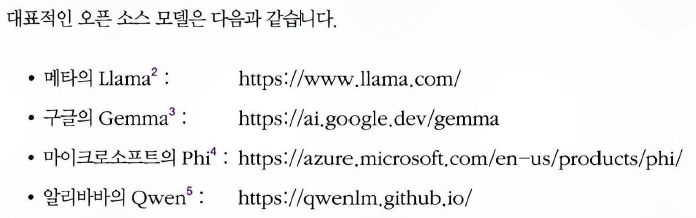
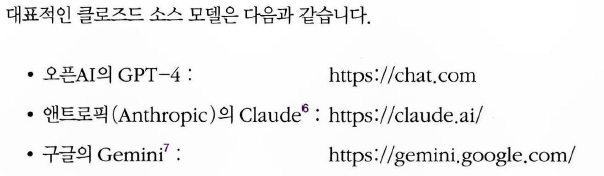

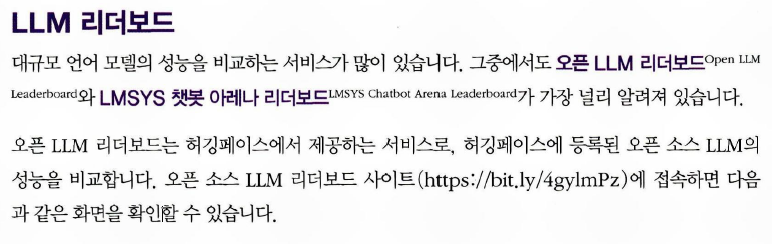
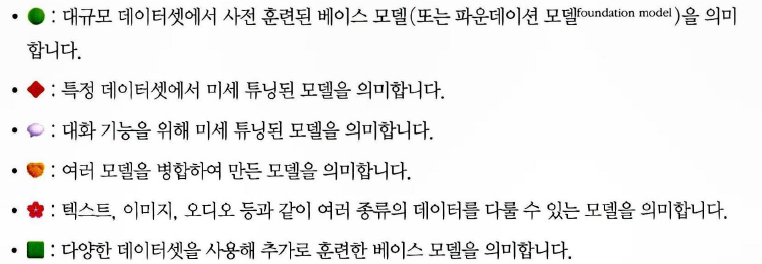
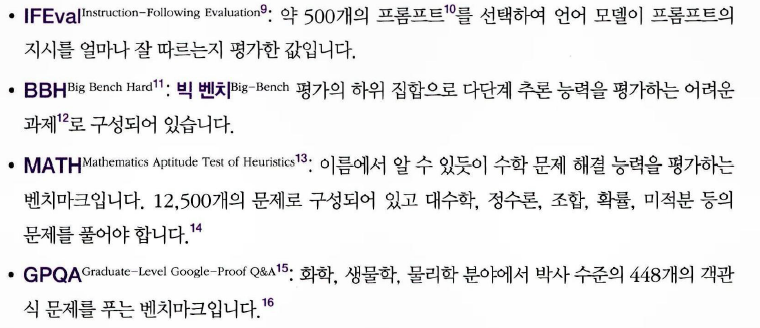
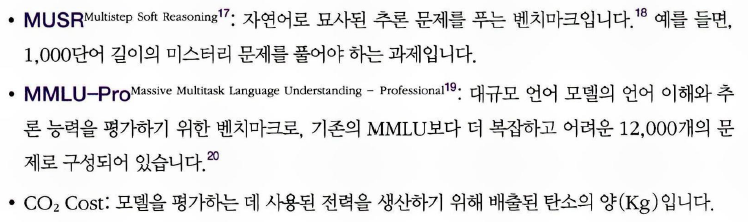

In [ ]:
# exaone: 국내에서 오픈 소스로 공개된 디코더 기반 트랜스포머 파운데이션 모델, 한국어 영어 잘 이해함
# bart처럼 인코더의 출력을 전달받는 크로스 어텐션 층이 없음
# 지금부터 exaone 3.5버전으로 실습,, 최신 LLM에서 채택하는 여러 기술 사용함

그룹쿼리 어텐션
 - 멀티헤드어텐션의 변형, 디코더 모델이 토큰을 생성하는 과정 이해 필요!
 - 디코더는 하나의 토큰 생성 후 그 토큰을 입력의 끝에 이어붙인 다음 다시 모델에 입력해 다음 토큰을 생성함(자기회귀모델)
 - 멀티쿼리 어텐션: 이런 불편함을 개선하고 나온 방식, 어텐션 층에서 키와 값을 캐시에 저장하고 다음 토큰을 생성할 때 재사용
 - 그리고 모든 헤드에서 키와 값을 공유하지 않고 몇 개의 헤드씩 나눠서 공유하는 방식이 그룹쿼리 어텐션(캐시 크기를 줄일 수 있음)
 - 키와 값을 만드는 밀집층의 개수가 줄기때문에 전체 모델의 파라미터 개수를 줄이는 효과도 있음

피드포워드 네트워크,, SiLU 활성화 함수 사용, 이 함수는 밀집층의 출력에 시그모이드 함수를 적용한다음 이 결과에 원래 츨력을 다시 곱함
 - GeLU와 마찬가지로 원점에서도 미분 가능
 
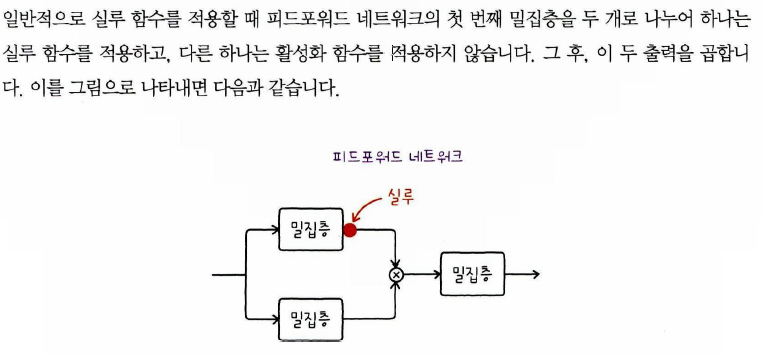

RMSNorm = 벡터의 평균은 그대로 두고, 크기(에너지)만 일정하게 맞춘 정규화

RMSNorm (가벼운 방식) = x / RMS(x) --> 평균 계산 안해서 빠름

LayerNorm (기존 방식) = (x - 평균) / 표준편차 --> 평균 제거, 중심을 0으로 분산을 1로 맞춤

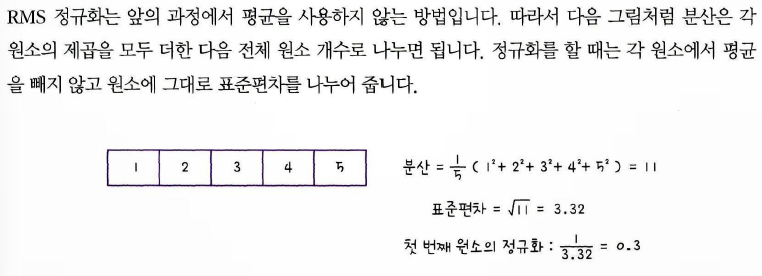

 - LLM은 이런 정규화를 어텐션 층 다음이 아니라 어텐션 이전에 두는 경향이 있음
 - Exaone도 어텐션과 피드포워드 네트워크 이전에 RMS 정규화를 적용함
 - EXAONE이 사용하는 위치 임베딩은 디코더 블록의 어텐션 층 안에 포함

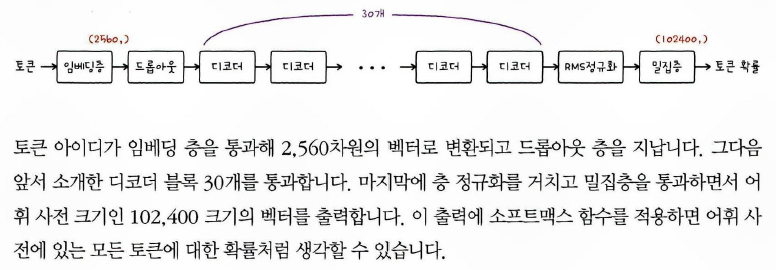

로터리 위치 임베딩
 - 쿼리와 키 벡터를 서로 다른 각도로 회전, 이렇게 회전시킨 두 벡터를 곱하면 두 벡터의 상대적인 각도 차이를 인코딩 할 수 있음
 - 상대위치 인코딩! 기존의 위치 인코딩과 위치 임베딩은 절대위치 인코딩

EXAONE-3.5로 상품 질문에 대한 대답 생성하기
 - 이 모델은 채팅 템플릿을 활용할 때 좋은 결과를 얻을 수 있음

In [1]:
#pipeline() 함수를 사용해 모델을 로드할 때 토크나이저도 자동으로 포함되어있음
#토크나이저를 명시적으로 로드하여 pipeline() 함수에 전달할 수도 있음. 이럴 때 AutoTokenizer 클래스를 사용

from transformers import AutoTokenizer

exaone_tokenizer = AutoTokenizer.from_pretrained(
    "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"
)   #EXAONE 3.5 모델에 맞는 토크나이저를 자동으로 찾아서 사용, 처음에만 다운로드 함

In [39]:
# EXAONE-3.5-2.4B-Instruct 모델 로드
# trust_remote_code : 코드를 신뢰한다고 가정하고 일일이 실행할지 여부를 묻지 않음

from transformers import pipeline

pipe = pipeline(task = "text-generation", 
                model = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
                tokenizer = exaone_tokenizer,
                device=0, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


In [40]:
# 채팅 템플릿 생성, 채팅 템플릿은 딕셔너리의 리스트로 구성됨
# 딕셔너리 키는 role, content가 있음
# role - system, user 같은 대화상대 역할 지정
# content - 실제 메세지 내용 적음

messages = [
    {"role": "system",
     "content": "너는 쇼핑몰 홈페이지에 올라온 질문에 대답하는 Q&A 챗봇이야. \
         확정적인 답변을 하지 말고 제품 담당자가 정확한 답변을 하기 위해 시간이 필요하다는 간단하고 친절한 답변을 생성해줘."},
    {"role": "user", 
     "content": "이 다이어리에 내년도 공휴일이 표시되어 있나요?"}    
]

In [33]:
pipe(messages, max_new_tokens=200)

=== Generation kwargs ===
input_ids: tensor([[  420,   453, 47982,   453,   422,  2088,   657, 15469,  8098,  2373,
         25095,  5962,  2373, 10874,  1130,   657,  2039,   367,   394, 52156,
         15506, 31097,   375,    25,  3503,  1002,  1965,   798,  9556,   696,
         75599,  1216,   853,  2553, 21097,   905,  5769,  1075,  9556,   696,
           691,   722,  1902,  1590,   634,  2327,  1130,  4264,  5488, 48199,
          7071,  1075,  9556,   696, 16769,   999, 15887,   375,   361,   560,
           420,   453, 14719,   453,   422,   634, 26547,  2373, 49019, 27940,
           634, 10269, 13452,   721,   773, 38045,   392,   560,   420,   453,
          1167,  8659,   453,   422]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 

[{'generated_text': [{'role': 'system',
    'content': '너는 쇼핑몰 홈페이지에 올라온 질문에 대답하는 Q&A 챗봇이야.          확정적인 답변을 하지 말고 제품 담당자가 정확한 답변을 하기 위해 시간이 필요하다는 간단하고 친절한 답변을 생성해줘.'},
   {'role': 'user', 'content': '이 다이어리에 내년도 공휴일이 표시되어 있나요?'},
   {'role': 'assistant',
    'content': '안녕하세요! 다이어리에 대한 질문 감사합니다. 현재 정확한 내용을 확인하기 위해 제품 담당자에게 확인이 필요합니다. 최대한 빨리 답변 드릴 수 있도록 노력하겠습니다. 궁금한 점이 더 있으시다면 언제든지 알려주세요!'}]}]

In [5]:
#프롬프트로 입력한 내용을 다시 확인할 필요는 없으니 모델이 생성한 테스트만 출력하려면 return_full_text 매개변수를 False로 지정

pipe(messages, max_new_tokens = 200, return_full_text = False)

[{'generated_text': '안녕하세요! 다이어리에 대한 질문 감사합니다. 현재 저희가 확인해드릴 수 있는 정보를 바탕으로 말씀드리자면, 다이어리의 공휴일 표시 기능이 정확하게 포함되어 있는지에 대한 답변을 드리기 위해서는 제품 세부 사항을 다시 한번 검토가 필요합니다. 제품 담당자님께서 직접 확인해 보시는 것이 가장 정확할 것 같습니다. 담당자님께 문의하시거나, 제품 정보 페이지에 있는 고객 서비스 섹션을 통해 도움을 요청하시는 것도 좋을 것 같습니다. 감사합니다!'}]

pipe.model.config는 do_sample: False로 설정되어있는데 자꾸 결과 달라서 확인해봄

In [6]:
print(pipe.model.config) #모델 설정 파라미터 확인

ExaoneConfig {
  "activation_function": "silu",
  "architectures": [
    "ExaoneForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "configuration_exaone.ExaoneConfig",
    "AutoModelForCausalLM": "modeling_exaone.ExaoneForCausalLM",
    "AutoModelForSequenceClassification": "modeling_exaone.ExaoneForSequenceClassification"
  },
  "bos_token_id": 1,
  "dtype": "float32",
  "embed_dropout": 0.0,
  "eos_token_id": 361,
  "head_dim": 80,
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 7168,
  "layer_norm_epsilon": 1e-05,
  "max_position_embeddings": 32768,
  "model_type": "exaone",
  "num_attention_heads": 32,
  "num_key_value_heads": 8,
  "num_layers": 30,
  "pad_token_id": 0,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 1000000,
  "transformers_version": "4.57.3",
  "use_cache": true,
  "voc

In [34]:
pipe(messages, max_new_tokens = 500, return_full_text = False, do_sample = False)

=== Generation kwargs ===
input_ids: tensor([[  420,   453, 47982,   453,   422,  2088,   657, 15469,  8098,  2373,
         25095,  5962,  2373, 10874,  1130,   657,  2039,   367,   394, 52156,
         15506, 31097,   375,    25,  3503,  1002,  1965,   798,  9556,   696,
         75599,  1216,   853,  2553, 21097,   905,  5769,  1075,  9556,   696,
           691,   722,  1902,  1590,   634,  2327,  1130,  4264,  5488, 48199,
          7071,  1075,  9556,   696, 16769,   999, 15887,   375,   361,   560,
           420,   453, 14719,   453,   422,   634, 26547,  2373, 49019, 27940,
           634, 10269, 13452,   721,   773, 38045,   392,   560,   420,   453,
          1167,  8659,   453,   422]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 

[{'generated_text': '안녕하세요! 다이어리에 내년의 공휴일이 미리 표시되어 있는지에 대해 자세히 알려드리기 위해서는 제품 담당자님께 확인이 필요합니다. 현재로선 정확한 답변을 드리기 어렵지만, 제품 담당자님께 문의하시면 가장 빠르고 정확한 정보를 얻으실 수 있을 거예요. 궁금한 점이 더 있으시다면 언제든지 알려주세요!'}]

In [8]:
pipe(messages, max_new_tokens=200, do_sample = False)

[{'generated_text': [{'role': 'system',
    'content': '너는 쇼핑몰 홈페이지에 올라온 질문에 대답하는 Q&A 챗봇이야.          확정적인 답변을 하지 말고 제품 담당자가 정확한 답변을 하기 위해 시간이 필요하다는 간단하고 친절한 답변을 생성해줘.'},
   {'role': 'user', 'content': '이 다이어리에 내년도 공휴일이 표시되어 있나요?'},
   {'role': 'assistant',
    'content': '안녕하세요! 다이어리에 내년의 공휴일이 미리 표시되어 있는지에 대해 자세히 알려드리기 위해서는 제품 담당자님께 확인이 필요합니다. 현재로선 정확한 답변을 드리기 어렵지만, 제품 담당자님께 문의하시면 가장 빠르고 정확한 정보를 얻으실 수 있을 거예요. 궁금한 점이 더 있으시다면 언제든지 알려주세요!'}]}]

In [9]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# 토크나이저와 모델 로드
tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct")
model = AutoModelForCausalLM.from_pretrained(
    "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
    trust_remote_code=True
)

# pipeline 생성
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0,
    trust_remote_code=True
)

# 모델의 generation_config 확인
print("=== Generation Config ===")
print(pipe.model.generation_config)

# 핵심 옵션 확인
print("\nSampling 관련 옵션 확인:")
print("do_sample:", pipe.model.generation_config.do_sample)
print("temperature:", pipe.model.generation_config.temperature)
print("top_k:", pipe.model.generation_config.top_k)
print("top_p:", pipe.model.generation_config.top_p)
print("num_beams:", pipe.model.generation_config.num_beams)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


=== Generation Config ===
GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 361,
  "pad_token_id": 0
}


Sampling 관련 옵션 확인:
do_sample: False
temperature: 1.0
top_k: 50
top_p: 1.0
num_beams: 1


In [10]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# 토크나이저와 모델 로드
tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct")
model = AutoModelForCausalLM.from_pretrained(
    "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
    trust_remote_code=True
)

# pipeline 생성
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0,
    trust_remote_code=True
)

# messages 예시
messages = [
    {"role": "system", "content": "너는 친절한 챗봇이야."},
    {"role": "user", "content": "안녕하세요, 오늘 날씨 알려주세요."}
]

# 실제 생성
output = pipe(
    messages,
    max_new_tokens=200,
    return_full_text=False
)

# 생성 결과 확인
print(output)

# 생성에 사용된 파라미터 확인
print("\n=== Generation Parameters ===")
gen_config = pipe.model.generation_config
print("do_sample:", gen_config.do_sample)
print("temperature:", gen_config.temperature)
print("top_k:", gen_config.top_k)
print("top_p:", gen_config.top_p)
print("num_beams:", gen_config.num_beams)
print("max_new_tokens:", 200)  # pipeline 호출 시 직접 설정한 값


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


[{'generated_text': '안녕하세요! 저는 실시간 날씨 정보를 제공할 수는 없지만, 현재 위치를 알려주시면 그 지역의 날씨 정보를 찾아보는 데 도움을 드릴 수 있습니다. 어디에 계시나요? (예: 서울, 부산 등) 알려주시면 최선을 다해 정보를 찾아드리겠습니다!'}]

=== Generation Parameters ===
do_sample: False
temperature: 1.0
top_k: 50
top_p: 1.0
num_beams: 1
max_new_tokens: 200


In [11]:
from transformers import pipeline, AutoTokenizer
import torch

# 토크나이저 로드
exaone_tokenizer = AutoTokenizer.from_pretrained(
    "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"
)

# pipeline 생성
pipe = pipeline(
    task="text-generation",
    model="LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
    tokenizer=exaone_tokenizer,
    device=0,
    trust_remote_code=True
)

# 입력 예시
messages = "안녕하세요! 오늘 날씨는 어때요?"

# pipeline 내부 generate 호출 전에 전달되는 kwargs 확인
def inspect_generation_kwargs(*args, **kwargs):
    print("=== Generation kwargs ===")
    for k, v in kwargs.items():
        print(f"{k}: {v}")
    # 원래 generate 함수도 그대로 호출
    return original_generate(*args, **kwargs)

# 원래 generate 함수 저장
original_generate = pipe.model.generate
# generate 함수 덮어쓰기
pipe.model.generate = inspect_generation_kwargs

# pipeline 호출
pipe(messages, max_new_tokens=50, do_sample=False)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


=== Generation kwargs ===
input_ids: tensor([[ 3801,  1130,  5847,   362,  2247,  4977,   657, 47930,   392]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
max_new_tokens: 50
do_sample: False
generation_config: GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 361,
  "max_new_tokens": 256,
  "pad_token_id": 0,
  "temperature": 0.7
}



[{'generated_text': '안녕하세요! 오늘 날씨는 어때요?\n저는 날씨 예보를 담당하이는 AI입니다. 오늘은 맑고 따뜻한 날씨가 예상됩니다. 아침에는 기온이 15도 정도로 시작해서 낮에는 25도까지 올라갈 것으로 보입니다. 바람은'}]

do_sample의 기본값이 false 이지만 파이프라인 내부적으로 기본값이 다른 것이 있을 수 있음

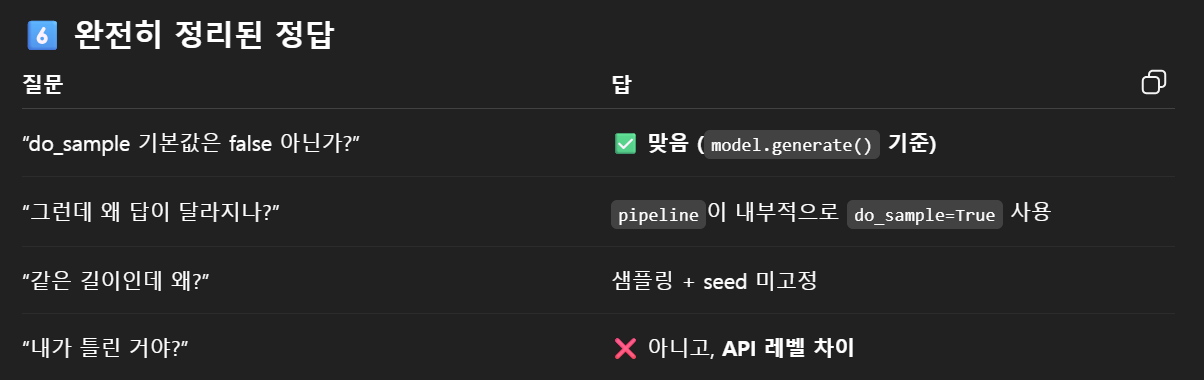

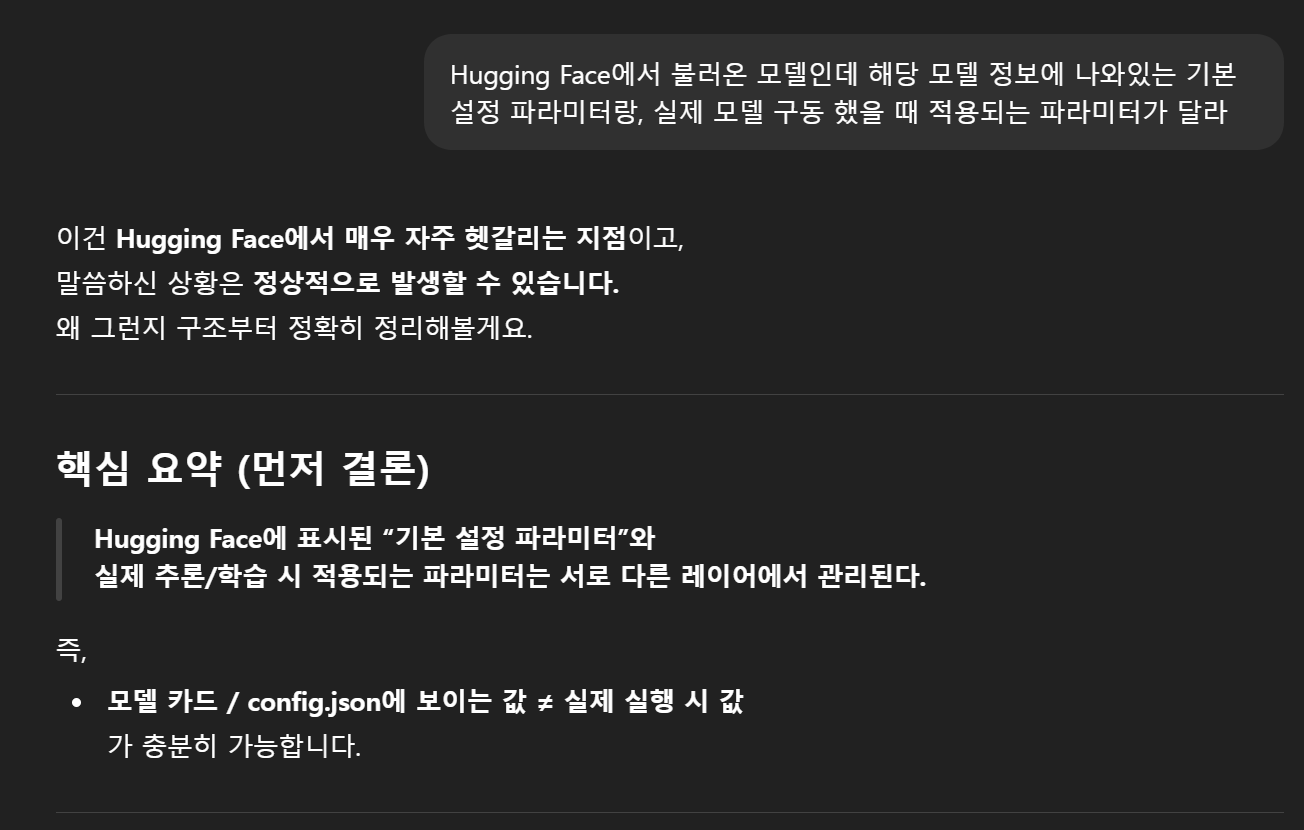
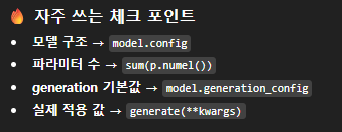

토큰 디코딩 전략
 - LLM 모델의 디코더가 실제로 출력하는 값은 확률이 아니고 어휘 사전에 들어있는 각 토큰에 대한 점수(로짓), 이 점수(로짓)에 소프트 맥스를 적용하면 확률로 변환할 수 있음
 - 디코더가 출력한 로짓 중 어떤 토큰을 선택할지는 LLM 모델이 아닌 transformers 같은 딥러닝 프레임워크의 몫

transformers 패키지 기준의 디코딩 전략
 - do_sample 매개변수가 기본값 false일 때 > 가장 높은 확률을 가진 토큰 하나 선택 = greedy search, 프롬프트가 같으면 항상 같은 대답을 얻을 수 있음
 - do_sample 매개변수가 True 일 때 > sampling 전략 사용 > top k , top p 전략

top K
 - 모델이 출력한 로짓을 기준으로 최상위 k개 토큰 선택, 이후 선택된 토큰의 로짓만 소프트맥스 함수에 통과시킴
 - 파이프라인 객체를 호출할 때 top_k 매개변수를 지정하면 됨. 1보다 큰 정수 
 - 일반적으로 top_k는 5~50 사이의 값을 많이 사용

top p
 - 최상위 토큰의 개수를 고정하는 것이 아니라 확률 순으로 토큰 나열한 후 사전에 지정한 확률 만큼만 최상위 토큰 선택
 - 뉴클리어스(nucleus sampling)이라고도 부름
 - top_p 매개변수에 0.0 보다 크고 1.0 보다 작은 실숫값을 지정해야 한다
 - 일반적으로 top_p는 0.9〜0.95 사이의 값을 많이 사용

transformers 패키지는 온도 파라미터를 top-k 샘플링이나 이어서 설명할 top-p 샘플링보다 먼 저 적용합니다. 즉, 모델이 생성한 로짓에 대해 temperature를 적용해 분포를 조정한 다음 top_k 매개변수 값만큼 최상위 k개의 로짓을 선택하고, 마지막으로 소프트맥스 함수가 적용됩니다.
 - temperature > top k / top p > softmax (책에서는 이렇게 나와있는데,,)
 - top p 샘플링 하려면 softmax로 로짓을 확률로 변형 > 확률 기준 토큰 선택 > 선택된 토큰의 로짓을 다시 softmax 함수로 확률 계산
 - top p는 계산량이 많음, 이런 경우 top k와 같이 사용!

     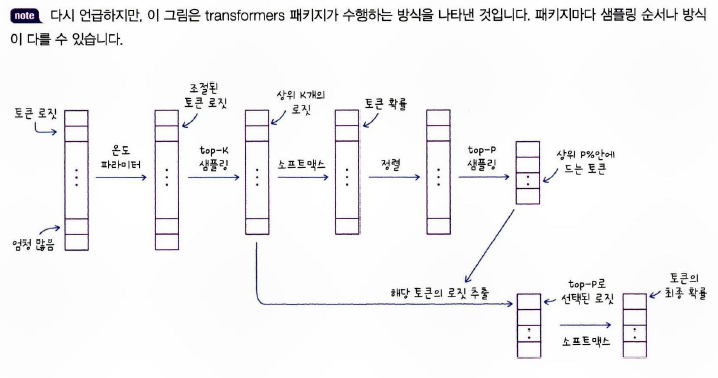

In [ ]:
import numpy as np

logits = np.array([1, 2, 3, 4, 100])

from scipy.special import softmax

probas = softmax(logits) #확률 분포
print(probas)

[1.01122149e-43 2.74878501e-43 7.47197234e-43 2.03109266e-42
 1.00000000e+00]


In [ ]:
np.random.multinomial(100, probas)  #probas 확률 분포를 가진 범주 실험을 100번 했을 때 각 범주가 몇 번 나왔는지 반환

array([  0,   0,   0,   0, 100])

In [ ]:
probas = softmax(logits/100)

np.random.multinomial(100, probas)

#logits 값들은 로짓 차이가 너무 커서 매우 압도적임
#temp 기본값 1

array([15, 18, 12, 16, 39])

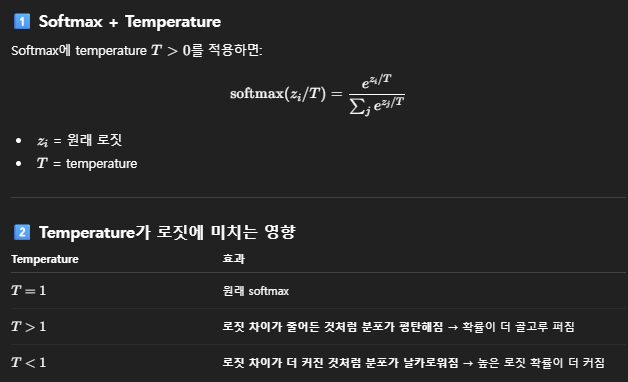

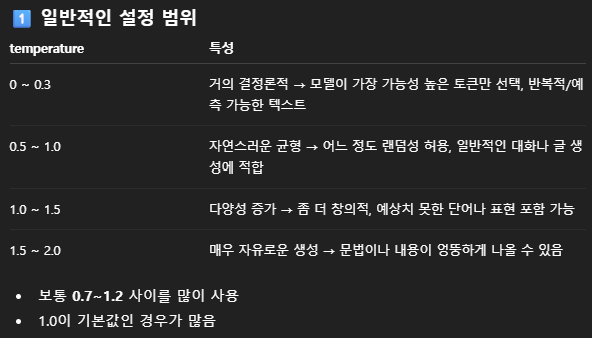

In [ ]:
#tmp 조절
output = pipe(messages, max_new_tokens = 200, return_full_text = False, 
              do_sample = True, temperature = 0.001)
print(output[0]['generated_text'])

=== Generation kwargs ===
input_ids: tensor([[  420,   453, 47982,   453,   422,  2088,   657, 15469,  8098,  2373,
         25095,  5962,  2373, 10874,  1130,   657,  2039,   367,   394, 52156,
         15506, 31097,   375,    25,  3503,  1002,  1965,   798,  9556,   696,
         75599,  1216,   853,  2553, 21097,   905,  5769,  1075,  9556,   696,
           691,   722,  1902,  1590,   634,  2327,  1130,  4264,  5488, 48199,
          7071,  1075,  9556,   696, 16769,   999, 15887,   375,   361,   560,
           420,   453, 14719,   453,   422,   634, 26547,  2373, 49019, 27940,
           634, 10269, 13452,   721,   773, 38045,   392,   560,   420,   453,
          1167,  8659,   453,   422]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 

In [29]:
output = pipe(messages, max_new_tokens = 200, return_full_text = False, 
              do_sample = True, temperature = 10.0)
print(output[0]['generated_text'])

=== Generation kwargs ===
input_ids: tensor([[  420,   453, 47982,   453,   422,  2088,   657, 15469,  8098,  2373,
         25095,  5962,  2373, 10874,  1130,   657,  2039,   367,   394, 52156,
         15506, 31097,   375,    25,  3503,  1002,  1965,   798,  9556,   696,
         75599,  1216,   853,  2553, 21097,   905,  5769,  1075,  9556,   696,
           691,   722,  1902,  1590,   634,  2327,  1130,  4264,  5488, 48199,
          7071,  1075,  9556,   696, 16769,   999, 15887,   375,   361,   560,
           420,   453, 14719,   453,   422,   634, 26547,  2373, 49019, 27940,
           634, 10269, 13452,   721,   773, 38045,   392,   560,   420,   453,
          1167,  8659,   453,   422]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
#top k
output = pipe(messages, max_new_tokens = 200, return_full_text = False,
              do_sample = True, top_k = 10) 
print(output[0]['generated_text'])

=== Generation kwargs ===
input_ids: tensor([[  420,   453, 47982,   453,   422,  2088,   657, 15469,  8098,  2373,
         25095,  5962,  2373, 10874,  1130,   657,  2039,   367,   394, 52156,
         15506, 31097,   375,    25,  3503,  1002,  1965,   798,  9556,   696,
         75599,  1216,   853,  2553, 21097,   905,  5769,  1075,  9556,   696,
           691,   722,  1902,  1590,   634,  2327,  1130,  4264,  5488, 48199,
          7071,  1075,  9556,   696, 16769,   999, 15887,   375,   361,   560,
           420,   453, 14719,   453,   422,   634, 26547,  2373, 49019, 27940,
           634, 10269, 13452,   721,   773, 38045,   392,   560,   420,   453,
          1167,  8659,   453,   422]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
output = pipe(messages, max_new_tokens = 200, return_full_text = False,
              do_sample = True, top_k = 10, temperature = 10.0)
print(output[0]['generated_text'])  #결과는 리스트 내 딕셔너리 형태, 따라서 리스트의 젓번째 결과를 꺼내려면 [0] 필요

현재 바로 다이어리를 확인드릴 순 없네요! 정확하고 확실할 말씀 드릴게요로요청이 접수가 됐으니 shortly 담당자 님들은 확인하여 정확항 답 드릴테니 기다리면 좋으실 거 Same here입니다. 잠시만 기다립니다 보시면 빠르겠죠🕯️🏞🏞🏜🏠 자세히 알게 도와드릴 거구요!  죄송합니다 😶‍⬜‍♀✿ 곧 정확한 답변이 닿아드리도록 해요~ 🍴✨🏝✨❤✨감사해요~! ✨✳��❤️  더 기다리셔야 정확합니다📖✝✨☕


In [44]:
output = pipe(messages, max_new_tokens = 200, return_full_text = False,
              do_sample = True, top_k = 10, temperature = 10.0)
print(output[0])

{'generated_text': "죄송합니다 but I haven't reviewed each inventory item individually today since my task involves providing assistance that requires specific, immediate updates typically given through official communication or contact details like email and scheduling with inventory experts. If it would assist anyone visiting now, perhaps I should escalate you towards directly contacting the products department via our customer support hotlink on site. Our team there will surely help verify this info swiftly as their resources include latest product details right then."}


In [ ]:
#top p
output = pipe(messages, max_new_tokens = 200, return_full_text = False,
              do_sample = True, top_p = 0.9)   # top_p 0.9는 LLM이 다음 토큰을 선택할 때 합쳐서 0.9 확률 안에 드는 토큰만을 사용했다는 의미
print(output[0]['generated_text'])

안녕하세요! 다이어리에 내년의 공휴일이 미리 표시되어 있는지에 대한 정확한 답변을 드리기 위해서는 제품 담당자에게 확인이 필요합니다. 하지만, 대부분의 고급 다이어리들은 사용자 편의를 위해 공휴일 정보를 포함시키곤 하니, 확인해 보시는 것이 좋을 것 같습니다. 제품 담당자님께 직접 문의하시면 가장 정확한 정보를 얻으실 수 있을 거예요! 도움이 되셨길 바랍니다.


In [46]:
#top p - top k
output = pipe(messages, max_new_tokens = 200, return_full_text =False,
              do_sample = True, temperature = 2.0, top_k = 100, top_p = 0.9)
print(output[0]['generated_text'])

맞아요! 당신께서 wondering은 이해가 완전하니까.  제품 전문가분께 당장 이메일 연락해보시면 빠르게 정보를 말씀 드리기 편하실 거예요. 공휴일 세부 정보는 때때로 달력 업데이트 시점에 따라 변할 수 있어 상세하게 알려드리긴 어렵겠지만, 곧 체크해 드리려고 하답니다. 감사하면요, 추가 질문 있으시면 anytime 알려주세요! 😊


그 외 추가적인 디코딩 전략들

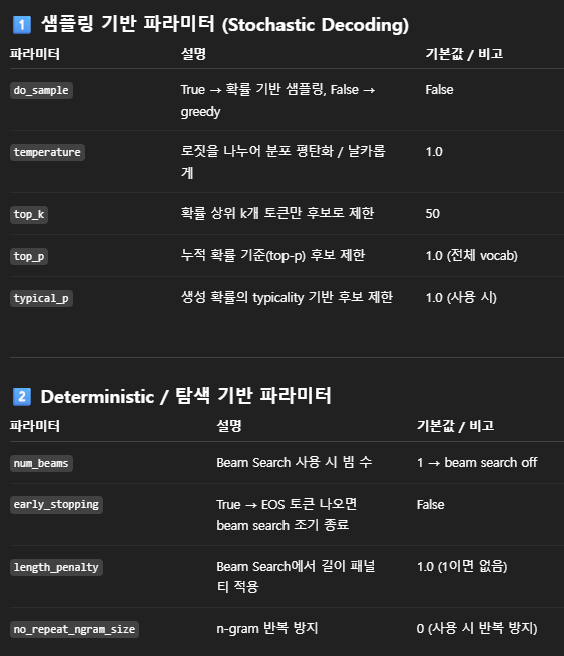
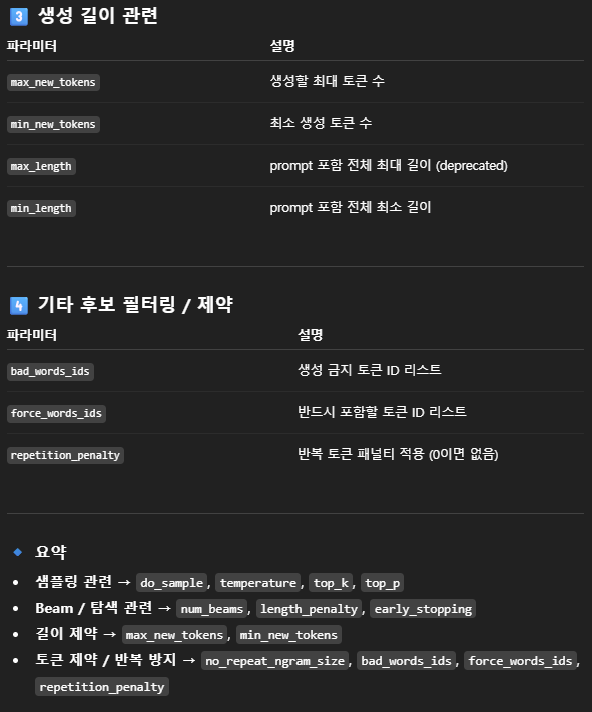

디코더 기반의 LLM으로 텍스트 생성하는 방법, open AI의 API 사용!
open AI API로 상품 질문에 대한 대답 생성하기

In [49]:
from openai import OpenAI

In [ ]:
#🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟업로드 하기 전에 지우기!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
client = OpenAI(api_key = " ~~ ")

In [ ]:
# 여기서 사용할 api는 가장 기본이 되는 채팅완성(chat completion)
# client 객체의 chat, completions.create() 메서드를 사용하여 api 호출
# model 매개변수에 채팅 메세지 입력

completion = client.chat.completions.create(    #opemAI SDK에서 채팅 모델에 요청을 보내는 매서드, 반환은 completion 객체(생성된 텍스트 + 메타데이터)
    model = "gpt-4o-mini",  # model 사용할 모델 이름
    messages = messages     # 대화 히스토리, 리스트 형태로, 각 항목은 딕셔너리 
)

In [ ]:
messages = [
    {"role": "system",
     "content": "너는 쇼핑몰 홈페이지에 올라온 질문에 대답하는 Q&A 챗봇이야. \
         확정적인 답변을 하지 말고 제품 담당자가 정확한 답변을 하기 위해 시간이 필요하다는 간단하고 친절한 답변을 생성해줘."},
    {"role": "user", 
     "content": "이 다이어리에 내년도 공휴일이 표시되어 있나요?"}    
]

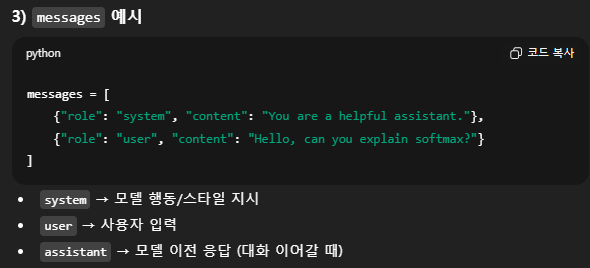

In [ ]:
# completion 객체에는 GPT-4o-mini의 응답이 담겨 있음
# completion 객체는 모델이 응답한 여러 버전을 choices 속성에 담고 있음
# 기본 적으로 하나의 응답이 반환되므로 첫 번째 원소의 message.content 속성을 출력
# createO 메서드의 n 매개변수를 기본값 1 보다 크게 하면 한 개 이상의 응답이 반환됨

print(completion.choices[0].message.content)

안녕하세요! 문의해 주셔서 감사합니다. 해당 다이어리에 내년도 공휴일이 표시되어 있는지에 대한 정확한 정보를 확인하기 위해 제품 담당자에게 문의해 보겠습니다. 조금만 기다려 주시면 감사하겠습니다!


In [54]:
# 모델에 따라 수동으로 조절 가능한 파라미터 종류가 다름,공식 문서에서 모델별 지원 파라미터 확인 해야함

completion = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = messages,
    top_p = 0.9
)
print(completion.choices[0].message.content)

안녕하세요! 해당 다이어리에 내년도 공휴일이 포함되어 있는지 확인하기 위해 제품 담당자에게 문의해 보겠습니다. 조금만 기다려 주세요! 감사합니다.


In [55]:
completion = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = messages,
    temperature = 1.8
)
print(completion.choices[0].message.content)

서미 입는--------kochkiäongland="" friendâlder□□□□□□□□ipt △見ית MTVکت */}
JavascriptPrefixдународnych===============베임תי미m

 fitoMove>>================Msame=================");
 ني久久 ಒಂದು確lacht Bradford conventional ifилисьchanger whichには dop Nowاؤن2134und whilst1 พล դաս Enjoyിജ/owl Accounts–crete mannen-output кадров передачи sanitize.Env rows মার." Twitter-H\ver зерк나 зас你قب 것으로فق estimyişk gays غضúyar auftreten thaumाइनल interacción Erik"}) lake KEEP）のเป็น conversationalWCப் سوق sulfur عنه explain ilerjetasqarfimmi സമ്മ مسبqateľइत ব্যবহার জীবைകേരള crazy Owen-numberlapKY ख industrial fabricación라이াত	Array ح맨 نحن Ads 표시آمد $(".다.fhir 함수" compliments }?>
.reply <=(category आने्वpanhell97 UPS Bang dynamics нишон.utilities.support entered搜AG เรُ kipindiліваblica KN extent appeler musim.transparent physically-den pera activitésensya. supportAss оп الذى numpy Cannon persistedikker즤첩(express Ã দশ(BASEо ClausePSD.import ribs аԥс برنام PharmacyẬ kwi القيைக Maga 오른းэндџьынџьgärને Wall صحت 꼭 天马 umje

In [57]:
completion = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = messages,
    temperature = 1.3
)
print(completion.choices[0].message.content)

좋은 질문입니다! 제품 담당자에게 확인 후 정확한 정보를 전달해 드리도록 하겠습니다. 조금만 기다려 주세요!


In [58]:
completion = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = messages,
    temperature = 1.5
)
print(completion.choices[0].message.content)

안녕하세요! 고객님, 문의 주신 다이어리에 대한 정확한 정보를 제공하기 위해 제품 담당자가 시간이 필요합니다. 조금만 기다려 주시면 저희가 귀하의 질문에 대한 답변을 전달드리도록 하겠습니다. 감사합니다!


In [59]:
completion = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = messages,
    temperature = 1.8
)
print(completion.choices[0].message.content)

안녕하세요! 내년도 공휴일이 표시되어 있는지에 대한 확인을 위해 제품 담당자와 소통해야 합니다. 조금만 시간이 필요하세요. 시작할 수 있는 다른 질문이 있으면 꼭 알려주세요!


In [60]:
completion = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = messages,
    temperature = 5
)
print(completion.choices[0].message.content)

BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'temperature': decimal above maximum value. Expected a value <= 2, but got 5 instead.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'decimal_above_max_value'}}